# **Adversarial Loss**

in this notebook is contained a brief but complete guide on adversarial loss, including theoretical background, application and implementation examples.

Author:  
@jwpr-dpr  
16-04-2025

## **Introduction to Adversarial Loss**

In recent years, *Generative Adversarial Networks* (GANs) have become one of the most exciting breakthroughs in deep learning. From creating photorealistic images to enabling high-quality image translation, the success of GANs can be largely attributed to a novel training strategy based on a concept known as **adversarial loss**.

But what exactly is adversarial loss?

In essence, adversarial loss arises from a **game between two neural networks**: a **Generator** (G) and a **Discriminator** (D). The generator's job is to produce data that resembles the real data, while the discriminator's task is to distinguish between real and fake data. These networks are trained together in a **minimax game** where:
- The generator tries to "fool" the discriminator by generating realistic data.
- The discriminator tries not to be fooled by correctly identifying real vs. fake samples.

This competition drives both networks to improve over time, resulting in a generator that produces data increasingly close to the real distribution.

In this guide, we will explore:
- The theoretical foundation of adversarial loss
- Different types of adversarial loss functions
- How these losses behave during training


## **Theoretical Background**

To understand adversarial loss, we first need to understand the setup of a **Generative Adversarial Network (GAN)**. A GAN consists of two components:

- **Generator (G)**: Takes in a random noise vector $ z \sim p_z $ and produces synthetic data $ G(z) $.
- **Discriminator (D)**: Takes in real data $ x \sim p_{\text{data}} $ and fake data $ G(z) $, and tries to classify them correctly.

The goal is to train these two models in a competitive game:
- The **discriminator** aims to **maximize** its ability to distinguish real from fake.
- The **generator** aims to **minimize** the discriminator's ability by producing data that looks real.

This interaction is formalized in the original GAN objective as:

$$
\min_G \max_D \, V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

---

Where:
- $ D(x) $: Probability that input $ x $ is real.
- $ D(G(z)) $: Probability that generated data is real.
- The discriminator wants $ D(x) \to 1 $ and $ D(G(z)) \to 0 $.
- The generator wants to "fool" the discriminator, i.e., push $ D(G(z)) \to 1 $.

This setup can be interpreted as a **two-player zero-sum game**:
- One player's gain is the other player's loss.
- Ideally, training reaches a **Nash equilibrium**, where $ G $ generates data indistinguishable from real, and $ D(x) = 0.5 $ for all inputs.


Despite its elegance, the original loss function has some **practical issues**:
- **Vanishing gradients**: If the discriminator gets too good early in training, $ \log(1 - D(G(z))) $ flattens out, and the generator stops learning.
- **Instability**: Training can be very sensitive to hyperparameters and initialization.

To address these issues, several alternative loss functions have been proposed:

| **Loss Name**          | **Discriminator Loss**                             | **Generator Loss**                                     | **Notes**                                                                 |
|------------------------|----------------------------------------------------|--------------------------------------------------------|--------------------------------------------------------------------------|
| Original GAN (minimax) | $ -\log D(x) - \log(1 - D(G(z))) $               | $ \log(1 - D(G(z))) $                                | Can lead to vanishing gradients                                          |
| Non-saturating GAN     | $ -\log D(x) - \log(1 - D(G(z))) $               | $ -\log D(G(z)) $                                    | Helps generator learn better in early training                          |
| Least Squares GAN      | $ (D(x) - 1)^2 + (D(G(z)))^2 $                   | $ (D(G(z)) - 1)^2 $                                  | Penalizes outputs based on distance from correct labels                 |
| Hinge Loss             | $ \max(0, 1 - D(x)) + \max(0, 1 + D(G(z))) $     | $ -D(G(z)) $                                         | Widely used in high-resolution image synthesis                         |
| WGAN                   | $ D(x) - D(G(z)) $                               | $ -D(G(z)) $                                         | Requires Lipschitz continuity (weight clipping or gradient penalty)     |
| WGAN-GP                | $ D(x) - D(G(z)) + \lambda \cdot \text{GP} $     | $ -D(G(z)) $                                         | Improves training stability with gradient penalty                       |

>  **GP** refers to the gradient penalty term that enforces Lipschitz continuity in WGAN-GP.

Each of these losses adjusts how the generator and discriminator receive feedback, impacting **stability, convergence speed**, and **output quality**.


In resume, Adversarial loss is more than a single equation — it’s a family of strategies built around the same idea: two networks trying to outsmart each other. Choosing the right variant for your task and tuning its training behavior are crucial to success in adversarial learning.

In the next section, we’ll begin implementing a minimal GAN using the original adversarial loss and visualize how it evolves during training.


## **Basic Implementation**

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### **Step 1: Define Generator and discriminator**

In [2]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, img_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability
        )

    def forward(self, x):
        return self.model(x)


### **Step 2: Load a Dataset**

In [3]:
# MNIST dataset (flattened)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.79MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


### **Step 3: Initialize Models, Loss and optimizers**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
img_dim = 28 * 28  # Flattened MNIST image

g = Generator(latent_dim, img_dim).to(device)
d = Discriminator(img_dim).to(device)

criterion = nn.BCELoss()
lr = 0.0002

optimizer_G = optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(d.parameters(), lr=lr, betas=(0.5, 0.999))


### **Step 4: Training loop with loss tracking**

In [5]:
epochs = 15

g_losses = []
d_losses = []
adv_losses = []

for epoch in range(epochs):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    num_batches = 0

    for i, (real_imgs, _) in enumerate(dataloader):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1).to(device)

        # Ground truths
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        ### 1. Train Discriminator ###
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = g(z)

        real_loss = criterion(d(real_imgs), real)
        fake_loss = criterion(d(fake_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        ### 2. Train Generator ###
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = g(z)
        g_loss = criterion(d(fake_imgs), real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        ### 3. Accumulate epoch losses ###
        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
        num_batches += 1

    # Average losses per epoch
    g_loss_epoch /= num_batches
    d_loss_epoch /= num_batches
    adv_loss_epoch = g_loss_epoch + d_loss_epoch

    g_losses.append(g_loss_epoch)
    d_losses.append(d_loss_epoch)
    adv_losses.append(adv_loss_epoch)

    print(f"Epoch [{epoch+1}/{epochs}] | G Loss: {g_loss_epoch:.4f} | D Loss: {d_loss_epoch:.4f} | Adv Loss: {adv_loss_epoch:.4f}")

torch.save(g.state_dict(), f'../test/gen_epoch_{epoch}.pth')
torch.save(d.state_dict(), f'../test/disc_epoch_{epoch}.pth')


Epoch [1/15] | G Loss: 1.5457 | D Loss: 0.8056 | Adv Loss: 2.3513
Epoch [2/15] | G Loss: 2.9369 | D Loss: 0.4855 | Adv Loss: 3.4224
Epoch [3/15] | G Loss: 3.5745 | D Loss: 0.4047 | Adv Loss: 3.9793
Epoch [4/15] | G Loss: 3.6247 | D Loss: 0.3537 | Adv Loss: 3.9783
Epoch [5/15] | G Loss: 4.0975 | D Loss: 0.2971 | Adv Loss: 4.3946
Epoch [6/15] | G Loss: 4.1081 | D Loss: 0.2773 | Adv Loss: 4.3854
Epoch [7/15] | G Loss: 3.8852 | D Loss: 0.3114 | Adv Loss: 4.1966
Epoch [8/15] | G Loss: 3.8281 | D Loss: 0.2991 | Adv Loss: 4.1272
Epoch [9/15] | G Loss: 3.1511 | D Loss: 0.4011 | Adv Loss: 3.5522
Epoch [10/15] | G Loss: 2.9505 | D Loss: 0.4494 | Adv Loss: 3.3998
Epoch [11/15] | G Loss: 2.7515 | D Loss: 0.4516 | Adv Loss: 3.2030
Epoch [12/15] | G Loss: 2.8550 | D Loss: 0.4896 | Adv Loss: 3.3445
Epoch [13/15] | G Loss: 2.9133 | D Loss: 0.5167 | Adv Loss: 3.4300
Epoch [14/15] | G Loss: 2.8385 | D Loss: 0.5824 | Adv Loss: 3.4210
Epoch [15/15] | G Loss: 2.8370 | D Loss: 0.6033 | Adv Loss: 3.4403


### **Step 5: Plot the loss curves**

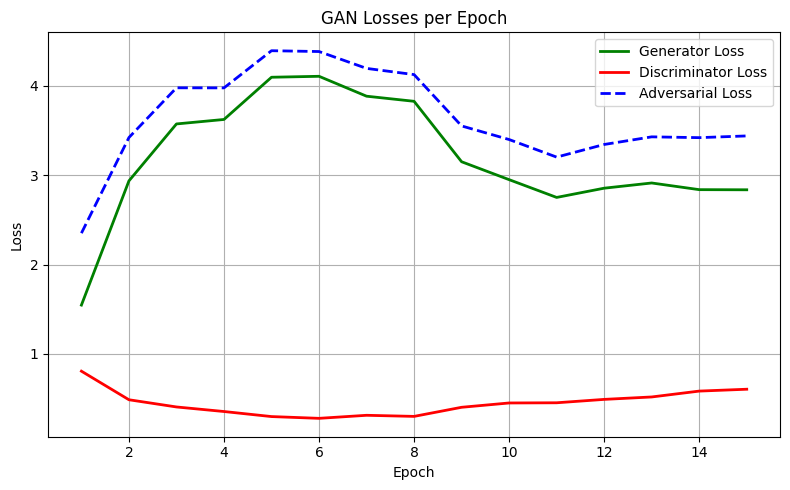

In [6]:
def plot_combined_losses(g_losses, d_losses, adv_losses):
    epochs = range(1, len(g_losses) + 1)
    plt.figure(figsize=(8, 5))
    
    plt.plot(epochs, g_losses, label="Generator Loss", color='green', linewidth=2)
    plt.plot(epochs, d_losses, label="Discriminator Loss", color='red', linewidth=2)
    plt.plot(epochs, adv_losses, label="Adversarial Loss", color='blue', linestyle='--', linewidth=2)
    
    plt.title("GAN Losses per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_losses(g_losses, d_losses, adv_losses)


And there you go. A very bad and undertrained model. The important thing here, is that now you know hot to perform adversarial loss.